<a href="https://colab.research.google.com/github/mancunian1792/causal_scene_generation/blob/master/causal_model/game_characters/image_classification_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
root_path = 'gdrive/My Drive/causal_scene_generation/game_characters/'
model1_name = "model-both-images.hdf5"
model2_name_img_split = "weights-10-0.930.hdf5"
test_path = root_path + 'test/'
test_images = test_path + 'images/'
test_csv = test_path + 'test.csv'

In [3]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from keras.preprocessing import image


Using TensorFlow backend.


### Using only the model with greater validation accuracy. Use the other model if in case the professor wants to compare. Ideally, the second model should be better for inference as it;s a straightforward problem for the model to solve as it identifies only an image with only one entity (either actor/reactor), character, type of character, entity doing something

In [4]:
# Modify the labels (Do - encoding)
splits_path = root_path + 'splits/'
splits_images = splits_path + 'images/'
splits_dataset = splits_path + 'split_dataset.csv'

In [5]:
df = pd.read_csv(splits_dataset)
images = df["img_name"]
#target = df.drop(["img_name"], axis=1)
#target = pd.get_dummies(target)

In [6]:
def processSplitImages(imgPath, filenames):
  images_data = []
  for img in tqdm(filenames):
    imgFullPath = imgPath + img + ".png"
    img = image.load_img(imgFullPath, target_size=(400,400,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    images_data.append(img)
  features = np.array(images_data)
  return features

In [ ]:
img_features = processSplitImages(splits_images, images)

100%|██████████| 864/864 [03:26<00:00,  4.18it/s]


In [7]:
model2 = keras.models.load_model(root_path+model2_name_img_split)

In [ ]:
'''
Input -> Name of the image (containing both the actor and the reactor)
Output -> Dictionary of the labels indicating the classes that the actor and reactor belong to

Steps:
1. Split the image in the middle.
2. For both the images, pre-process it and predict the probabilities
3. For a threshold of 0.7, find the classes that match those probabilities. (Hopefully it is 4 in all cases. Figure out a way to test them )
4. From the labels , format them in a desired format that could be passed directly to the causal model conditioning.

'''

'\nInput -> Name of the image (containing both the actor and the reactor)\nOutput -> Dictionary of the labels indicating the classes that the actor and reactor belong to\n\nSteps:\n1. Split the image in the middle.\n2. For both the images, pre-process it and predict the probabilities\n3. For a threshold of 0.7, find the classes that match those probabilities. (Hopefully it is 4 in all cases. Figure out a way to test them )\n4. From the labels , format them in a desired format that could be passed directly to the causal model conditioning.\n\n'

In [12]:
def get_prediction(img_path, model):
  img = image.load_img(img_path, target_size=(400,400,3), grayscale=False)
  img_left = img.crop((0,0,200,400)).resize((400,400))
  img_right = img.crop((200,0,400,400)).resize((400,400))
  img_left = image.img_to_array(img_left)
  img_left = img_left/255

  img_right = image.img_to_array(img_right)
  img_right = img_right/255

  plt.imshow(image.array_to_img(img))
  pred_left = model.predict(img_left.reshape(1,400,400,3))
  pred_right = model.predict(img_right.reshape(1,400,400,3))

  return class_from_prob(pred_left), class_from_prob(pred_right)

  #return dict(zip(keys, pred_left_map)), dict(zip(keys, pred_right_map))


  

In [18]:
def class_from_prob(prob):
  classes = np.array(['1', '2', '3', 'Attacking', 'Dying', 'Golem', 'Hurt', 'Idle',
       'Satyr', 'Taunt', 'Walking', 'actor', 'reactor'], dtype=object)
  mapping = dict(zip(classes, prob[0]))
  reverse_mapping = {value : key for (key, value) in mapping.items()}

  return {
      "entity": reverse_mapping[max(mapping["actor"], mapping["reactor"])],
      "type": reverse_mapping[max(mapping["1"], mapping["2"], mapping["3"])],
      "character": reverse_mapping[max(mapping["Satyr"], mapping["Golem"])],
      "entity_doing": reverse_mapping[max(mapping["Taunt"], mapping["Walking"], mapping["Hurt"], mapping["Idle"], mapping["Dying"], mapping["Attacking"])]
  }



  

({'character': 'Satyr',
  'entity': 'actor',
  'entity_doing': 'Attacking',
  'type': '1'},
 {'character': 'Satyr',
  'entity': 'reactor',
  'entity_doing': 'Attacking',
  'type': '3'})

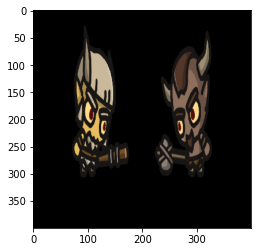

In [21]:
get_prediction(test_images+"combination27.png", model2)

['DataFrameIterator',
 'DirectoryIterator',
 'ImageDataGenerator',
 'ImageEnhance',
 'Iterator',
 'NumpyArrayIterator',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'affine_transformations',
 'apply_affine_transform',
 'apply_brightness_shift',
 'apply_channel_shift',
 'array_to_img',
 'dataframe_iterator',
 'directory_iterator',
 'division',
 'flip_axis',
 'image_data_generator',
 'img_to_array',
 'io',
 'iterator',
 'list_pictures',
 'load_img',
 'ndimage',
 'np',
 'numpy_array_iterator',
 'os',
 'pil_image',
 'print_function',
 'random_brightness',
 'random_channel_shift',
 'random_rotation',
 'random_shear',
 'random_shift',
 'random_zoom',
 'save_img',
 'scipy',
 'transform_matrix_offset_center',
 'utils',
 'validate_filename',
 'warnings']